# <center>Тестирование
**Задание 1.4**  
Задана функция, найдитее значение функции в точке $ x=(5, 13) $
$$ f(x_1, x_2) = \frac{1}{5}(x_1 + x_2 - 18)^2 + \frac{1}{8}(x_2 - x_1) $$

In [61]:
import sympy as sp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn import  tree

In [35]:
x_1, x_2 = sp.symbols('x_1 x_2', real=True)
f = 5**-1 * (x_1 + x_2 - 18)**2 + 8**-1 * (x_2 - x_1)
display(f)
f_dot = f.subs(x_1, 5).subs(x_2, 13)
print(f'Значение f в точке (5, 13) = {f_dot}')

-0.125*x_1 + 0.125*x_2 + 0.2*(x_1 + x_2 - 18)**2

Значение f в точке (5, 13) = 1.00000000000000


# <center>Алгоритм CART

In [36]:
data = pd.DataFrame({
    'age': [17, 64, 18, 20, 38, 49, 55, 25, 29, 31],
    'income': [25, 80, 22, 36, 37, 59, 74, 70, 33, 102],
    'loan': [1, 0, 1, 0, 1, 0, 0, 1, 1, 0]
})
x = data['age']
y = data['loan']
data

,age,income,loan
0,17,25,1
1,64,80,0
2,18,22,1
3,20,36,0
4,38,37,1
5,49,59,0
6,55,74,0
7,25,70,1
8,29,33,1
9,31,102,0


Сначала отсортируем фактор по возрастанию с помощью метода `sort_values()` и удалим из него дубликаты с помощью метода `drop_duplicates()`:

In [37]:
x = x.sort_values().drop_duplicates()
print(x.values)

[17 18 20 25 29 31 38 49 55 64]


Для вычисления скользящего среднего в Pandas можно воспользоваться комбинацией методов `rolling()` и `mean()`. В методе `rolling()` необходимо указать окно, в котором считается среднее (в нашем случае оно равно `2`):

In [38]:
x_roll_mean = x.rolling(2).mean()
print(x_roll_mean.values)

[ nan 17.5 19.  22.5 27.  30.  34.5 43.5 52.  59.5]


В результате вычисления скользящего среднего всегда будет образовываться один пропуск. Для его исключения воспользуемся методом `dropna()`:

In [39]:
x_roll_mean = x_roll_mean.dropna()
print(x_roll_mean.values)

[17.5 19.  22.5 27.  30.  34.5 43.5 52.  59.5]


Наконец, необходимо отфильтровать `x` так, чтобы в результат попали только те значения, при переходе через которые целевая переменная меняется. Для этого мы отсортируем `y` в соответствии с индексами `x`, затем вычислим разницу между соседними значениями `y` с помощью метода `diff()`. После этого произведём фильтрацию:

In [40]:
y = y[x_roll_mean.index]
y_roll_mean = y.diff()
candidates = x_roll_mean[y_roll_mean != 0]
print(candidates.values)

[17.5 19.  22.5 30.  34.5 43.5]


Удобнее будет оформить полученный алгоритм в виде функции `find_candidates_for_thresholds()`. 

In [41]:
def find_candidates_for_thresholds(x:pd.Series, y:pd.Series):
    x = x.sort_values().drop_duplicates()
    x_roll_mean = x.rolling(2).mean().dropna()
    y = y[x_roll_mean.index]
    y_roll_mean = y.diff()
    candidates = x_roll_mean[y_roll_mean != 0]
    return candidates.values

print(find_candidates_for_thresholds(data['age'], data['loan']))
print(find_candidates_for_thresholds(data['income'], data['loan']))

[17.5 19.  22.5 30.  34.5 43.5]
[23.5 34.5 36.5 48.  64.5 72. ]


**Задание 3.4**  
Дана часть датасета о домах в штате Айова, состоящая из 15 наблюдений.
Найдите уникальных кандидатов на пороговое значение $t$ для фактора $x_1$ (`Lot Frontage`).


In [42]:
ames_data = pd.read_csv('data/AmesHousing.zip')
ames_data = ames_data[(ames_data['Lot Frontage'] <=150) & (ames_data['Lot Area'] <=20000)]
ames_sample = ames_data[['Lot Frontage', 'Lot Area', 'SalePrice']].sample(
    n=15, #количество объектов
    random_state=42, #генератор случайных чисел
    ignore_index=True #сбрасываем счетчик индекса
)

find_candidates_for_thresholds(ames_sample['Lot Frontage'], ames_sample['SalePrice'])

array([ 53.,  58.,  61.,  65.,  69.,  71.,  76.,  86.,  94., 101.])

**Задание 3.5**  
Для части датасета о домах в Айове из предыдущего задания найдите уникальных кандидатов на пороговое значение $t$ для фактора $x_2$ (`Lot Area`).

In [43]:
find_candidates_for_thresholds(ames_sample['Lot Area'], ames_sample['SalePrice'])

array([ 5508. ,  7153. ,  7425. ,  7949. ,  8405.5,  8526.5,  8850. ,
        9137.5,  9466. , 10051.5, 10507. , 10834. , 11365. , 12288. ])

# <center>Ветвление. Неоднородность
## Задача регрессии
Для начала создадим функцию для расчёта среднего квадрата ошибки — `squared_error()`. Она будет принимать на вход истинные ответы и возвращать значение MSE, рассчитанное для входных данных.


In [44]:
def squared_error(y):
    y_pred = y.mean()
    return ((y - y_pred) ** 2).mean()

Далее нам необходимо реализовать функцию `split()`, которая разбивает выборку $(X, y)$ по предикату $[x_j \leq t]$ с параметрами разделения (`split_params`) на левую и правую части:



In [45]:
def split(X, y, split_params):
    j, t = split_params
    predicat = X.iloc[:, j] <= t
    X_left, y_left = X[predicat], y[predicat]
    X_right, y_right = X[~predicat], y[~predicat]
    return X_left, y_left, X_right, y_right

Затем создадим функцию `calculate_weighted_impurity()`. Она будет принимать на вход выборку — `X` и `y`, параметры разбиения — `split_params`, а также `criterion` — функцию, по которой рассчитывается критерий информативности (`у` нас это функция `squared_error()`). Результатом работы функции будет взвешенная неоднородность после разбиения.



In [46]:
def calculate_weighted_impurity(X, y, split_params, criterion):
    X_left, y_left, X_right, y_right = split(X, y, split_params)
    N, N_left, N_right  = y.size, y_left.size, y_right.size
    score = N_left / N * criterion(y_left) + N_right / N * criterion(y_right)
    return score

Наконец, финальный шаг — построить решающий пень. Для этого необходимо оформить в виде цикла отбор кандидатов в параметры разбиения и найти оптимальные из них. За данный шаг будет отвечать функция `best_split()`. Она будет принимать на вход выборку (`X` и `y`) и возвращать оптимальные параметры разбиения, при которых значение взвешенной неоднородности минимально.



In [47]:
def best_split(X, y, criterion):
    M = X.shape[1]
    min_weighted_impurity = np.inf
    optimal_split_params = None
    for j in range(M):
        thresholds = find_candidates_for_thresholds(X.iloc[:, j], y)
        for t in thresholds:
            split_params = (j, t)
            weighted_impurity = calculate_weighted_impurity(X, y, split_params, criterion)
            if weighted_impurity < min_weighted_impurity:
                min_weighted_impurity = weighted_impurity
                optimal_split_params = split_params
    return optimal_split_params


Давайте протестируем функцию `best_split()` — возьмём датасет из нашего последнего примера:

In [48]:
data = pd.DataFrame({
    'x1': list(range(1, 16)),
    'y': [1, 1.2, 1.4, 1.1, 1, 5.5, 6.1, 6.7, 6.4, 6, 6, 3, 3.2, 3.1, 3]
})
X = data[['x1']]
y = data['y']

Чтобы найти параметры решающего пня, нам осталось только вызвать функцию `best_split()`, передав в неё выборку и функцию для расчёта критерия информативности:


In [49]:
# Находим оптимальные параметры разбиения
optimal_split_params = best_split(X, y, criterion=squared_error)
print('Optimal j: {}'.format(optimal_split_params[0]))
print('Optimal t: {}'.format(optimal_split_params[1]))

Optimal j: 0
Optimal t: 5.5


Мы получили следующее оптимальное решающее правило, которое разместим в корневой вершине: $B(x_j, t) = [x_1 \leq 5.5]$.

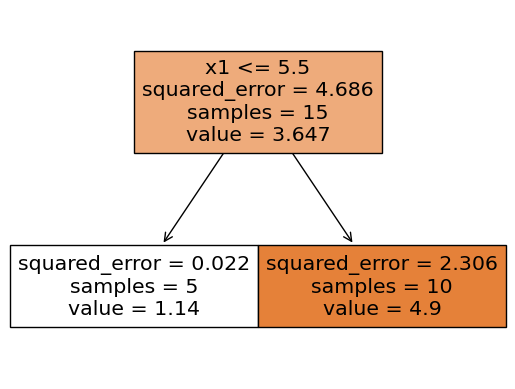

In [50]:
# Инициализируем модель дерева решений с максимальной глубиной 1 и обучаем её
dt = tree.DecisionTreeRegressor(
    max_depth=1, #глубина
    criterion='squared_error', #критерий информативности
    random_state=0 #генератор случайных чисел
)

dt.fit(X, y)
# Визуализируем дерево решений в виде графа
tree.plot_tree(
    decision_tree=dt, #дерево решений 
    feature_names=list(X.columns), #названия факторов
    filled=True, #расцветка
    impurity=True, #отображать ли неоднородность в вершинах
);

***
**Задание 4.3**  
Дана часть датасета о домах в штате Айова, состоящая из 15 наблюдений.

Найдите оптимальные для построения решающего пня параметры разбиения $j$ и $t$. В качестве критерия информативности используйте квадратичную ошибку.



In [51]:
ames_data = ames_data[(ames_data["Lot Frontage"] <=150) & (ames_data["Lot Area"] <=20000)]

ames_sample = ames_data[["Lot Frontage", "Lot Area", "SalePrice"]].sample(
    n=15, random_state=42, ignore_index=True
)

X = ames_sample[["Lot Frontage", "Lot Area"]]
y = ames_sample["SalePrice"]

optimal_split_params = best_split(X, y, criterion=squared_error)
print('Optimal j: {}'.format(optimal_split_params[0]))
print('Optimal t: {}'.format(optimal_split_params[1]))

Optimal j: 0
Optimal t: 71.0


Чему равно значение взвешенной неоднородности после разбиения при найденных оптимальных параметрах сплита?

In [52]:
calculate_weighted_impurity(X, y, optimal_split_params, squared_error)

1414654917.0222223

## Задача классификации
Сам алгоритм не изменится — просто вместо расчёта квадратичной ошибки мы будем рассчитывать критерий информативности для классификации, например энтропию.

Реализуем функцию `entropy()`, которая рассчитывает энтропию Шеннона. На вход функции приходит целевая переменная $y$. Далее с помощью функции `value_counts()` считаются доли каждого из классов — вероятности принадлежности к классам. Затем эти вероятности логарифмируются по основанию $2$, и рассчитывается энтропия.



In [53]:
def entropy(y):
    p = y.value_counts(normalize=True)
    entropy = -np.sum(p * np.log2(p))
    return entropy

Для вызова самой функции `best_split()` нужно будет только поменять критерий информативности (параметр `criterion`).

In [54]:
best_split(X, y, criterion=entropy)

(0, 65.0)

***
**Задание 4.5**  
Дана часть датасета о банкнотах, состоящая из 15 наблюдений.

Найдите оптимальные для построения решающего пня параметры разбиения $j$ и $t$. Для этого воспользуйтесь функцией `best_split()`, которую мы реализовали ранее. В качестве критерия информативности используется энтропию Шеннона.

In [55]:
bill_data = pd.read_csv('data/bill_authentication.zip')
bill_sample = bill_data[['Variance', 'Skewness', 'Class']].sample(
    n=15, 
    random_state=42, 
    ignore_index=True
)
# Создаём обучающую выборку
X = bill_sample[['Variance', 'Skewness']]
y = bill_sample['Class']

optimal_split_params = best_split(X, y, criterion=entropy)
print('Optimal j: {}'.format(optimal_split_params[0]))
print('Optimal t: {}'.format(optimal_split_params[1]))

Optimal j: 1
Optimal t: 3.22085


Чему равно значение взвешенной неоднородности после разбиения при найденных оптимальных параметрах сплита?

In [56]:
calculate_weighted_impurity(X, y, optimal_split_params, entropy)

0.45977313014931737

# <center>Построение дерева решений с помощью рекурсии

In [57]:
class Node:
    def __init__(self, left=None, 
                 right=None, value=None, 
                 split_params=None, impurity=None,
                 samples=None, is_leaf=False):
        self.left = left
        self.right = right
        self.split_params = split_params
        self.value = value
        self.impurity = impurity
        self.samples = samples
        self.is_leaf = is_leaf

def create_leaf_prediction(y):
    value = y.mode()[0]
    return value

def stopping_criterion(X, y, criterion):
    return criterion(y) == 0

def build_decision_tree(X, y, criterion):
    if stopping_criterion(X, y, criterion):
        value = create_leaf_prediction(y)
        node = Node(
            value=value, 
            impurity=criterion(y), 
            samples=y.size,
            is_leaf=True
        )
    else:
        split_params = best_split(X, y, criterion=entropy)
        X_left, y_left, X_rigth, y_right = split(X, y, split_params)
        left = build_decision_tree(X_left, y_left, criterion)
        right = build_decision_tree(X_rigth, y_right, criterion)       
        node = Node(
            left=left, right=right, 
            split_params=split_params, 
            impurity=criterion(y), 
            samples=y.size
        )
    return node

def print_decision_tree(node, depth=0):
    depth += 1
    if node.is_leaf:
        print('   ' * depth, 'class: {}'.format(node.value))
    else:
        print('   ' * depth, 'feature_{} <= {:.3f}:'.format(*node.split_params))
        print_decision_tree(node.left, depth=depth)
        print('   ' * depth, 'feature_{} > {:.3f}:'.format(*node.split_params))
        print_decision_tree(node.right, depth=depth)
        
# Создаем обучающую выборку
data = pd.DataFrame({
    'age': [17, 64, 18, 20, 38, 49, 55, 25, 29, 31],
    'income': [25, 80, 22, 36, 37, 59, 74, 70, 33, 102],
    'loan': [1, 0, 1, 0, 1, 0, 0, 1, 1, 0]
})
X = data[['age', 'income']]
y = data['loan'] 
# Строим дерево решений и печатаем его на экран
decision_tree = build_decision_tree(X, y, criterion=entropy)
print_decision_tree(decision_tree)

    feature_0 <= 43.500:
       feature_1 <= 86.000:
          feature_0 <= 22.500:
             feature_0 <= 19.000:
                class: 1
             feature_0 > 19.000:
                class: 0
          feature_0 > 22.500:
             class: 1
       feature_1 > 86.000:
          class: 0
    feature_0 > 43.500:
       class: 0


***
**Задание 5.3**  
Дана часть датасета о банкнотах, состоящая из 15 наблюдений.  
Постройте дерево решений на обучающей выборке с помощью функции build_decision_tree(). В качестве критерия информативности используйте энтропию Шеннона.


In [58]:
bill_data = pd.read_csv('data/bill_authentication.zip')
bill_sample = bill_data[['Variance', 'Skewness', 'Class']].sample(
    n=15, 
    random_state=42, 
    ignore_index=True
)
# Создаём обучающую выборку
X = bill_sample[['Variance', 'Skewness']]
y = bill_sample['Class']

decision_tree = build_decision_tree(X, y, entropy)
print_decision_tree(decision_tree)

    feature_1 <= 3.221:
       feature_0 <= 2.756:
          feature_0 <= -1.254:
             class: 0
          feature_0 > -1.254:
             feature_0 <= -0.063:
                class: 1
             feature_0 > -0.063:
                feature_0 <= 0.988:
                   class: 0
                feature_0 > 0.988:
                   class: 1
       feature_0 > 2.756:
          class: 0
    feature_1 > 3.221:
       class: 0


## <center>Критерий остановки
В реализации дерева решений в sklearn предусмотрено несколько критериев, при выполнении одного из которых ветвление дерева прекращается. Мы рассмотрим основные из них на примере нашего «игрушечного» датасета о выплатах кредита.

In [59]:
data = pd.DataFrame({
    'age': [17, 64, 18, 20, 38, 49, 55, 25, 29, 31],
    'income': [25, 80, 22, 36, 37, 59, 74, 70, 33, 102],
    'y': [1, 0, 1, 0, 1, 0, 0, 1, 1, 0]
})
# Создаём обучающую выборку
X = data[['age', 'income']]
y = data['y']

1. **ДОСТИЖЕНИЕ ОДНОРОДНОСТИ**

    Этот критерий остановки мы уже использовали при построении своего дерева. Он является основным, то есть действует, если исследователем не установлены другие ограничения.

    Критерий гласит: ветвление дерева решений прекращается, когда неоднородность вершины, определяемая критерием информативности? минимальна, то есть $H(Q)=0$.

    Для задачи **классификации** это условие означает, что все объекты в вершине являются объектами одного класса.

    Для задачи **регрессии** это условие означает, что средняя ошибка предсказания вершины равна нулю.

    Для примера построим дерево решений, используя наш «игрушечный» датасет. При этом все параметры оставим по умолчанию. Получим следующее дерево:

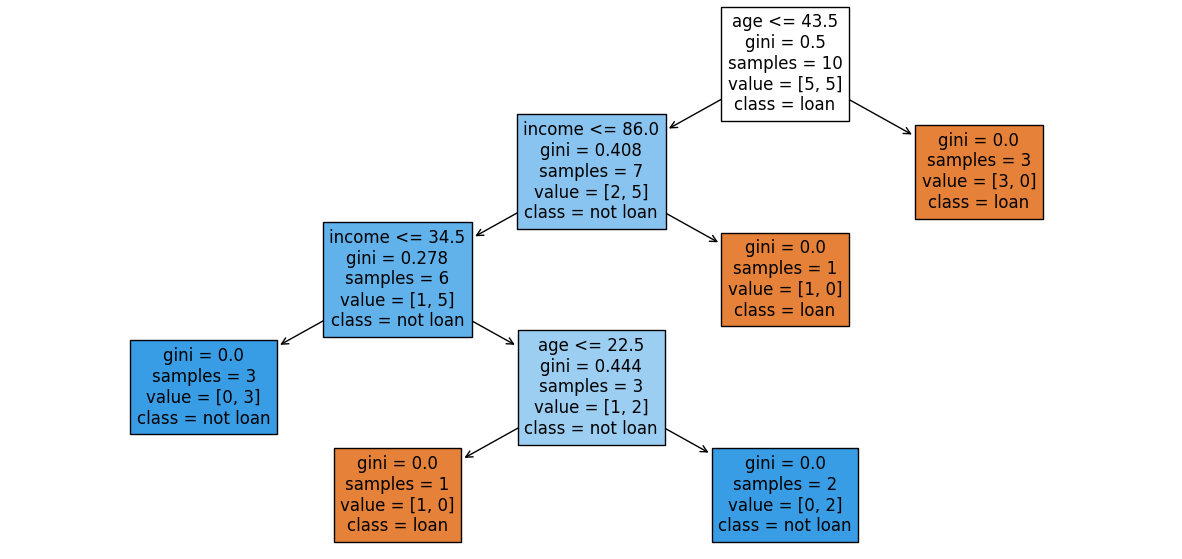

In [63]:
dt = tree.DecisionTreeClassifier(random_state=42)
dt.fit(X, y)

fig = plt.figure(figsize=(15, 7))
tree_graph = tree.plot_tree(
    decision_tree=dt, 
    feature_names=list(X.columns), 
    class_names=['loan', 'not loan'], 
    filled=True, 
    impurity=True
);

Обратите внимание, что во всех листовых вершинах неоднородность, обозначенная как `gini`, равна 0, а в самих листьях содержатся объекты (`value`) только одного определённого класса.

2. **ОГРАНИЧЕНИЕ МАКСИМАЛЬНОЙ ГЛУБИНЫ ДЕРЕВА (ПАРАМЕТР `MAX_DEPTH`)**

    Идея состоит в том, что, когда дерево достигает максимально заданной глубины, ветвление прекращается. С точки зрения программной реализации, это означает ограничение глубины рекурсии.

    По умолчанию глубина дерева не ограничена. Помните, что ограничение глубины дерева решений является основным методом борьбы с его переобучением.

    В качестве примера ограничим глубину нашего дерева решений до 3:

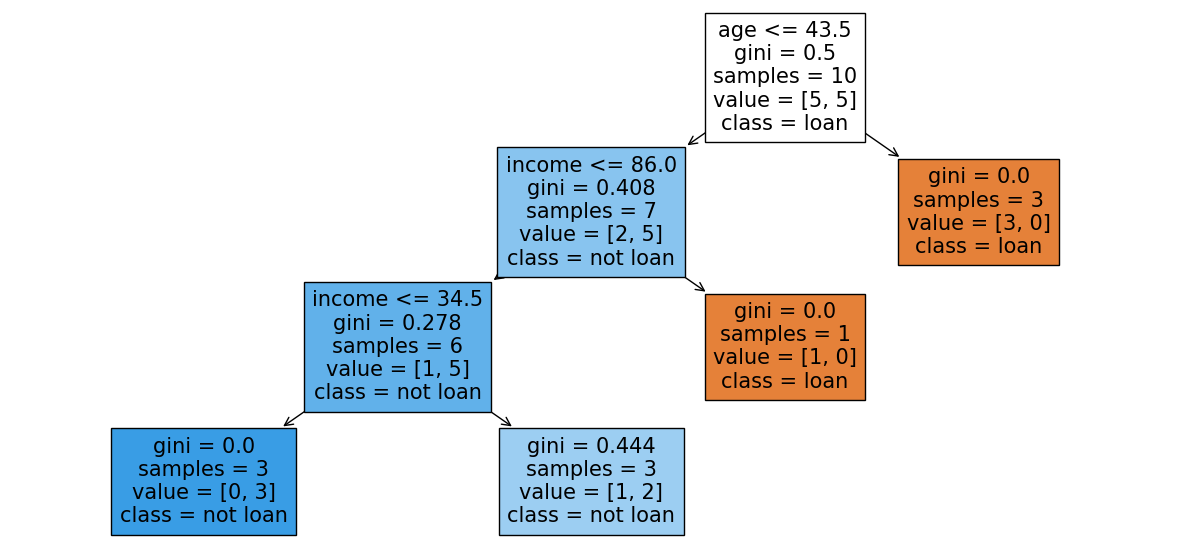

In [64]:
dt = tree.DecisionTreeClassifier(
    max_depth=3, 
    random_state=42
)
dt.fit(X, y)

fig = plt.figure(figsize=(15, 7))
tree_graph = tree.plot_tree(
    decision_tree=dt, 
    feature_names=list(X.columns), 
    class_names=['loan', 'not loan'], 
    filled=True, 
    impurity=True
);

В результате мы получили обрезанную версию дерева, которое видели ранее.

3. **ОГРАНИЧЕНИЕ МАКСИМАЛЬНОГО КОЛИЧЕСТВА ЛИСТЬЕВ В ДЕРЕВЕ (ПАРАМЕТР `MAX_LEAF_NODE`)**

    Здесь всё происходит по аналогии с максимальной глубиной дерева: мы задаём максимальное количество листьев, которое может быть в дереве — когда количество листьев в дереве достигает этой верхней планки, ветвление прекращается.

    По умолчанию количество листьев не ограничено. Как и все критерии остановки, ограничение на количество листьев может служить инструментом борьбы с переобучением дерева.

    Для примера ограничим количество листьев в нашем дереве до 3:

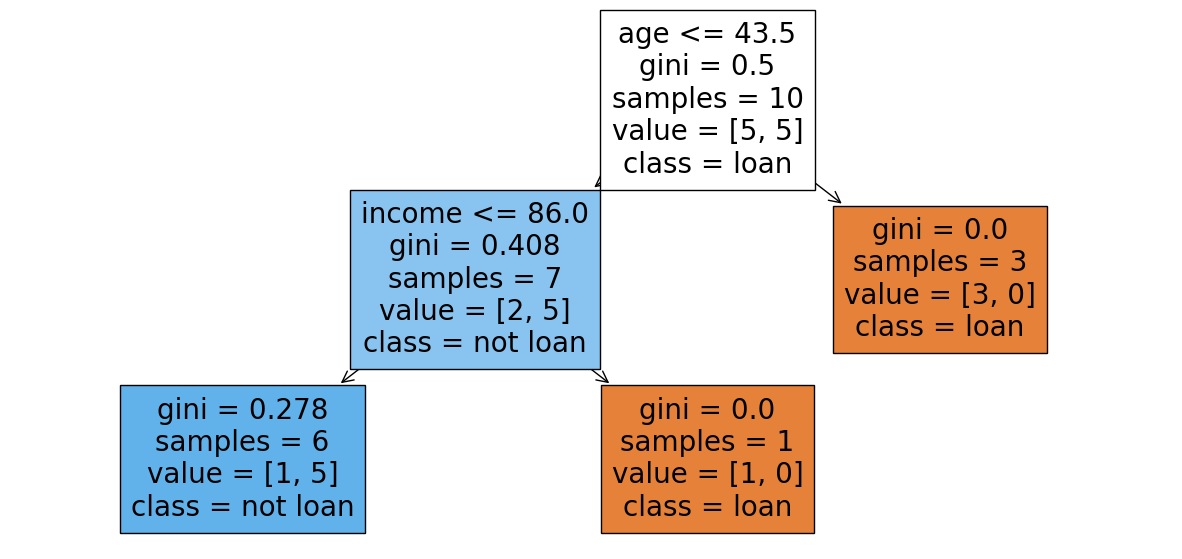

In [65]:
dt = tree.DecisionTreeClassifier(
    max_leaf_nodes=3, 
    random_state=42
)
dt.fit(X, y)

fig = plt.figure(figsize=(15, 7))
tree_graph = tree.plot_tree(
    decision_tree=dt, 
    feature_names=list(X.columns), 
    class_names=['loan', 'not loan'], 
    filled=True, 
    impurity=True
);

Видим, что из-за ограничения на количество листьев в дереве разделения по предикату $[\text{income} \leq 34.5]$ не произошло — вместо этого данная вершина превратилась в листовую, и итоговая глубина дерева уменьшилось с 4 до 3. Общее количество листьев в дереве, как мы и указывали, равно 3.

4. **ОГРАНИЧЕНИЕ НА МИНИМАЛЬНОЕ КОЛИЧЕСТВО ОБЪЕКТОВ, ПРИ КОТОРЫХ ДОПУСКАЕТСЯ ВЕТВЛЕНИЕ ДЕРЕВА (ПАРАМЕТР `MIN_SAMPLES_SPLIT`)**

    Идея ограничения проста, как и все предыдущие. Пусть в вершину попала выборка $Q_v$, количество объектов в этой вершине — $N_v=5$. При этом однородность в этой вершине не равна $0$.

    По идее, ветвление дерева должно быть продолжено. Однако если мы установим ограничение на минимальное количество объектов для разделения (`min_samples_split=6`), то разделения вершины не произойдёт.

    Для примера обучим дерево решений с параметром `min_samples_split=6`:

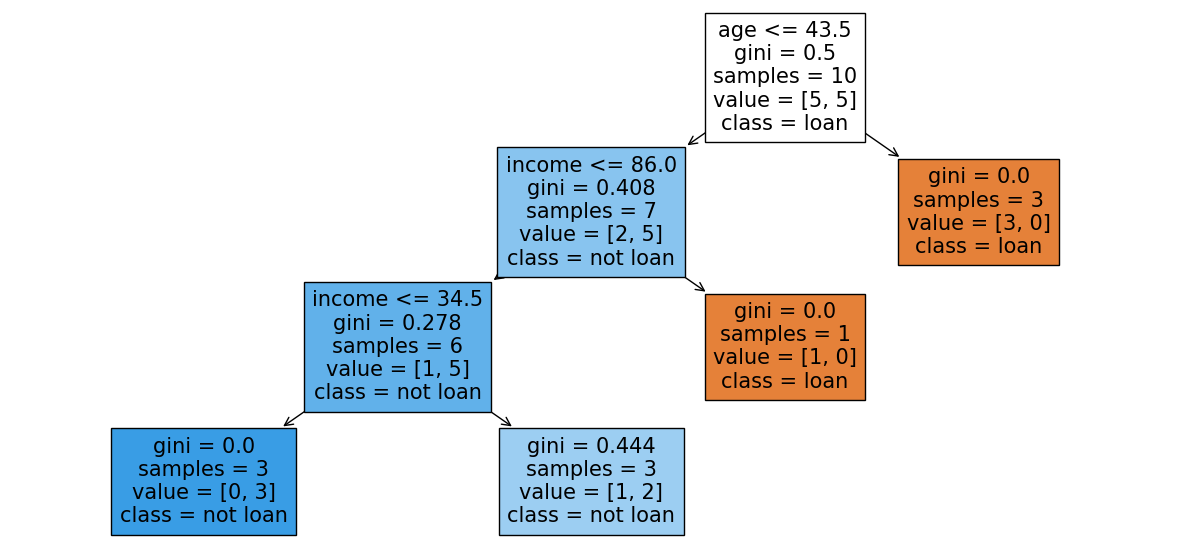

In [66]:
dt = tree.DecisionTreeClassifier(
    min_samples_split=6, 
    random_state=42
)
dt.fit(X, y)

fig = plt.figure(figsize=(15, 7))
tree_graph = tree.plot_tree(
    decision_tree=dt, 
    feature_names=list(X.columns), 
    class_names=['loan', 'not loan'], 
    filled=True, 
    impurity=True
);

Видим, что разделение по условию $[\text{income} \leq 34.5]$ произошло, так как количество объектов в вершине (`samples`), соответствующей ему, равно 6. А вот в вершинах, где количество наблюдений равно 3, разделения не произошло.

5. **ОГРАНИЧЕНИЕ НА МИНИМАЛЬНОЕ КОЛИЧЕСТВО ОБЪЕКТОВ, НЕОБХОДИМЫХ ДЛЯ СОЗДАНИЯ ЛИСТА (ПАРАМЕТР `MIN_SAMPLES_LEAF`)**

    Предположим, что при разделении выборки $Q_v$ на $Q_v^{\text{left}}$ и $Q_v^{\text{right}}$ с параметрами разделения $w$ случилось так, что в левую вершину попало $N_v^{\text{left}} = 3$ наблюдения, а в правую — $N_v^{\text{right}} = 2$, причём однородность в правой вершине — $G(Q_v^{\text{right}}, w) = 0$. При этом мы поставили ограничение `min_samples_leaf=3`. 

    В таком случае, даже несмотря на равенство нулю однородности в правой вершине, ветвления не произойдёт, так как минимальное количество объектов, которое допускается в листовой вершине, — 3. Это значит, что разделение вершины на две новых при таких параметрах разделения не будет произведено.

    Посмотрим на примере, как работает этот критерий. Обучим дерево решений с параметром `min_samples_leaf=3`:

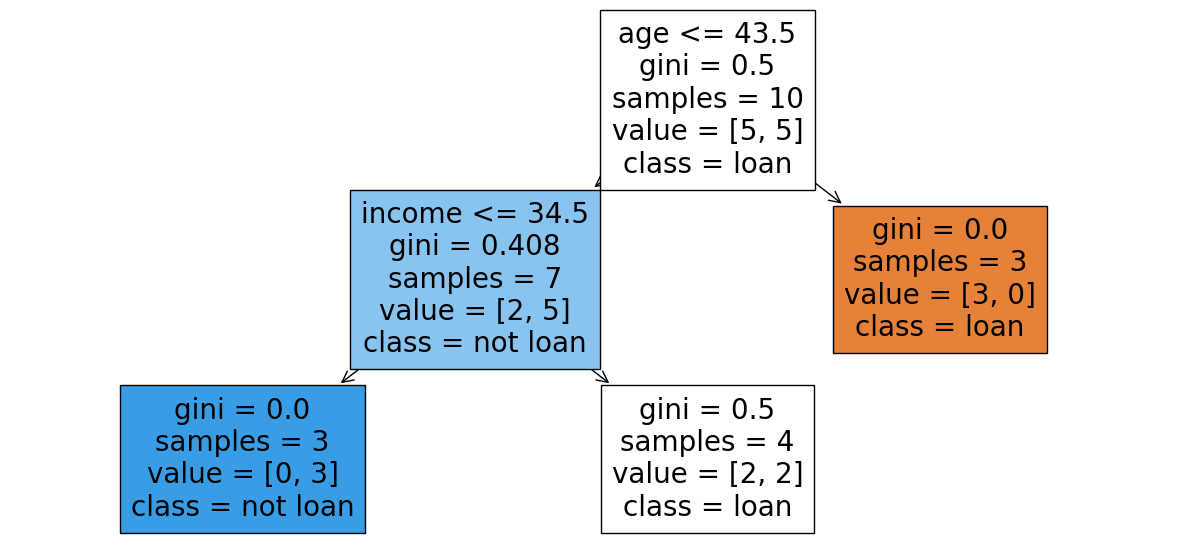

In [67]:
dt = tree.DecisionTreeClassifier(
    min_samples_leaf=3, 
    random_state=42
)
dt.fit(X, y)

fig = plt.figure(figsize=(15, 7))
tree_graph = tree.plot_tree(
    decision_tree=dt, 
    feature_names=list(X.columns), 
    class_names=['loan', 'not loan'], 
    filled=True, 
    impurity=True
);

Обратите внимание, что в вершине ранее находилось условие $\text{income} \leq 86$, а теперь там находится условие $\text{income} \leq 34.5$. Как это произошло?

На самом деле всё просто. При разделении по решающему правилу $\text{income} \leq 86$ у нас бы получались две новых вершины: в левой находилось бы шесть объектов, а в правой — один, причём правая вершина стала бы листовой. Однако у нас стоит ограничение: количество объектов в листовых вершин должно быть не менее 3. Поэтому такое разделение нам не подходит. Под данное условие подходит только одно решающее правило — . При таком разделении в левую вершину попадает три объекта, а в правую — четыре. После этого ветвление прекращается.
***
Давайте адаптируем наш метод построения дерева решений и введём новое ограничение на максимальную глубину дерева: в функции `stop_criterion()` и `build_decision_tree()` добавим параметр `max_depth`, а также счётчик глубины рекурсии `depth`:



In [68]:
def stopping_criterion(X, y, criterion, max_depth=None, depth=0):
    if max_depth is None:
        return (criterion(y) == 0) 
    else:
        return (criterion(y) == 0) or (depth > max_depth)
    
def build_decision_tree(X, y, criterion, max_depth=None, depth=0):
    depth += 1
    if stopping_criterion(X, y, criterion, max_depth, depth):
        value = create_leaf_prediction(y)
        node = Node(
            value=value, 
            impurity=criterion(y), 
            samples=y.size,
            is_leaf=True
        )
    else:
        split_params = best_split(X, y, criterion=entropy)
        X_left, y_left, X_right, y_right = split(X, y, split_params)
        left = build_decision_tree(X_left, y_left, criterion, max_depth, depth)
        right = build_decision_tree(X_right, y_right, criterion, max_depth, depth)       
        node = Node(
            left=left, right=right, 
            split_params=split_params, 
            impurity=criterion(y), 
            samples=y.size
        )
    return node

Чтобы проверить результат, построим дерево с максимальной глубиной 2. В качестве данных используем данные о кредитах:



In [69]:
# Строим дерево решений с ограничением глубины и выводим его на экран
decision_tree = build_decision_tree(X, y, criterion=entropy, max_depth=2)
print_decision_tree(decision_tree)

    feature_0 <= 43.500:
       feature_1 <= 86.000:
          class: 1
       feature_1 > 86.000:
          class: 0
    feature_0 > 43.500:
       class: 0


## <center> Значимость признаков
Реализуем функцию `calculate_feature_importances()` для расчёта относительных значимостей признаков. Она будет принимать на вход обученное дерево решений. Также у неё будет аргумент по умолчанию — массив из значимостей `feature_importances`. Так как функция будет рекурсивной, то при первом запуске массив нужно проинициализировать нулями.

Далее, до тех пор пока не «упрёмся» в листья, будем считать прирост информации для признака, записанного в вершине, и заносить результат в массив, затем рекурсивно проделывать то же самое для потомков. После окончания рекурсии образуется массив `feature_importances`, в котором будут лежать суммарные приросты информации по каждому из признаков. Чтобы получить относительную значимость признаков, нужно будет разделить массив на число наблюдений, а затем нормировать на сумму.



In [70]:
def calculate_feature_importances(node, feature_importance=None):
    if feature_importance is None:
        feature_importance = np.zeros(X.shape[1])
    if node.value is None:
        j = node.split_params[0]
        feature_importance[j] += node.impurity * node.samples - \
                                 node.left.impurity * node.left.samples - \
                                 node.right.impurity * node.right.samples
        calculate_feature_importances(node.left, feature_importance)
        calculate_feature_importances(node.right, feature_importance)
    feature_importance /= node.samples
    feature_importance /= feature_importance.sum()
    return feature_importance


Протестируем функцию на нашем «игрушечном» датасете о кредитах:



In [72]:
# Создаём обучающую выборку
data = pd.DataFrame({
    'age': [17, 64, 18, 20, 38, 49, 55, 25, 29, 31],
    'income': [25, 80, 22, 36, 37, 59, 74, 70, 33, 102],
    'loan': [1, 0, 1, 0, 1, 0, 0, 1, 1, 0]
})
X = data[['age', 'income']]
y = data['loan'] 
# Строим дерево решений и выводим его на экран
decision_tree = build_decision_tree(X, y, entropy)
# Вычисляем значения информативности признаков
print(calculate_feature_importances(decision_tree))

[0.78582905 0.21417095]


***
**Задание 6.3**  
Дано дерево решений, решающее задачу классификации людей на тех, кто зарабатывает > 50 тысяч долларов (класс 1), и тех, кто зарабатывает меньше этой суммы (класс 0).

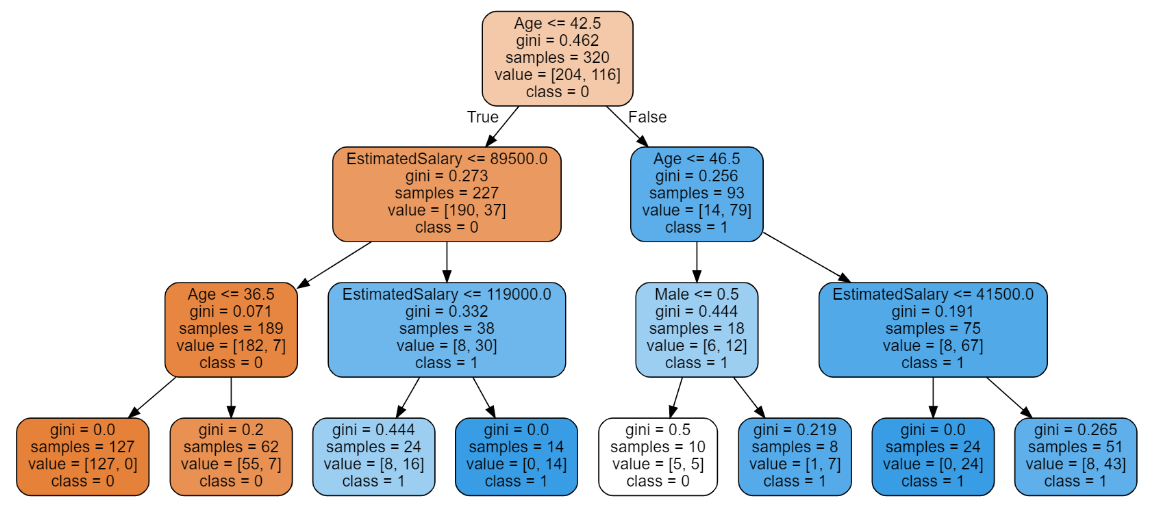

Рассчитайте абсолютную значимость признака возраст `age` для данного дерева.

In [79]:
F_age = ((320*0.462 - 227*0.273 - 93*0.256) + (189*0.071 - 127*0 - 62*0.2) + (93*0.256 - 18*0.444 - 75*0.191)) / 320
round(F_age, 3)

0.202